In [4]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

In [5]:
from mobo.surrogate_model import BoTorchSurrogateModelReapeat, BoTorchSurrogateModel
from mobo.transformation import StandardTransform
import numpy as np
import torch
import pandas as pd
from pathlib import Path
import numpy as np

In [6]:

# .\result\exp4d\optimization_4\marsdet\0\state_dict_noise.pt

path = Path("../result/exp4d/optimization_4/marsdet/0/")
# path = Path("../result/peaksS5R3/default/mars/0/")
# path = Path("../result/peaks/default/qnehvi/0/")

state_dict = torch.load(path / "state_dict.pt")
state_dict_noise = torch.load(path / "state_dict_noise.pt")

eval_samples = pd.read_csv(path / "EvaluatedSamples.csv")
eval_samples.columns.to_list()


# train_X = eval_samples[["x1", "x2", "x3", "x4"]].values
# use pandas filter to select columns
train_X = eval_samples.filter(regex="^x[0-9]").values
train_Y = eval_samples.filter(regex="^f[0-9]").values
train_Yvar = eval_samples.filter(regex="^rho_f[0-9]").values

import torch
#np to torch
train_X = torch.tensor(train_X, dtype=torch.float)
train_Y = -torch.tensor(train_Y, dtype=torch.float)
train_Yvar = torch.tensor(train_Yvar, dtype=torch.float)

# botorch cross validation
from botorch import cross_validation
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.cross_validation import batch_cross_validation, gen_loo_cv_folds
cv_folds = gen_loo_cv_folds(train_X, train_Y)
cv_results = batch_cross_validation(
    SingleTaskGP,
    ExactMarginalLogLikelihood,
    cv_folds,
)
# cv_results



In [7]:
# # Toy example
# train_X = torch.rand(30, 2)
# train_Y = torch.sin(6 * train_X) + 0.2 * torch.rand_like(train_X)
# # 2d

# cv_folds = gen_loo_cv_folds(train_X, train_Y)
# cv_results = batch_cross_validation(
#     SingleTaskGP,
#     ExactMarginalLogLikelihood,
#     cv_folds,
# )
# pred_posterior = cv_results.posterior
# pred_Y = pred_posterior.mean.squeeze()
# pred_Yvar = pred_posterior.variance.squeeze()

Mean Absolute Percentage Error for each objective: [58.52568  30.99725  25.080633]


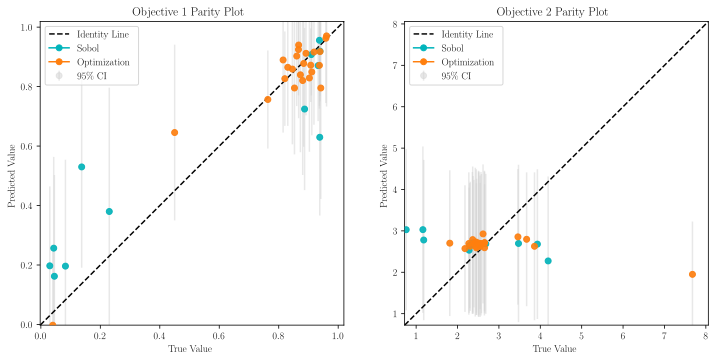

In [8]:
# train_Y = cv_results.observed_Y.squeeze()
# train_Yvar = cv_results.observed_Yvar.squeeze()
pred_posterior = cv_results.posterior
pred_Y = pred_posterior.mean.squeeze()
pred_Yvar = pred_posterior.variance.squeeze()
# pred_Yvar = cv_results.observed_Yvar.squeeze()


%config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"],
})

pred_Ystd = torch.sqrt(pred_Yvar)

# Prepare the plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

# bool array for sobol experiments vs optimization
sobol = np.array([i < 12 for i in range(len(train_Y))])

color_list = ["#01b4bb", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
colors = np.where(sobol, color_list[0], color_list[1])


for i in range(len(train_Y[0])-1):
    
    # Error bars for confidence intervals
    # Scatter plot for predictions vs. true values
    ax[i].errorbar(train_Y[:, i], pred_Y[:, i], yerr=1.96*pred_Ystd[:, i], fmt='o', color="lightgray", alpha=0.5, label="95\% CI")
    ax[i].scatter(train_Y[:, i], pred_Y[:, i], alpha=0.9, c=colors,
                  zorder=5,)
    
    
    # Identity line
    max_val = max(max(train_Y[:, i]), max(pred_Y[:, i])) * 1.05
    min_val = min(min(train_Y[:, i]), min(pred_Y[:, i])) * 0.95
    ax[i].plot([min_val, max_val], [min_val, max_val], 'k--', label="Identity Line")
    
    # Set limits for better comparison
    ax[i].set_xlim([ min_val, max_val])
    ax[i].set_ylim([ min_val, max_val])
    
    # Enhance labeling
    ax[i].set_xlabel("True Value")
    ax[i].set_ylabel("Predicted Value")
    ax[i].set_title(f"Objective {i+1} Parity Plot")
    ax[i].set_aspect('equal', adjustable='box')

    #empty plot for legend
    ax[i].plot([], [], color_list[0], label="Sobol", marker="o")
    ax[i].plot([], [], color_list[1], label="Optimization", marker="o")
    ax[i].legend()
    

# plt.show()    
plt.savefig(path / "parity_plot.pdf", dpi=600, format="pdf")

# Calculate and print MAPE for each objective
mape = torch.mean(torch.abs((train_Y - pred_Y) / train_Y), axis=0) * 100

 
print("Mean Absolute Percentage Error for each objective:", mape.numpy())
